# 1. 加载数据

In [1]:
import scipy 
import os
import socket
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
import time
from tqdm import tqdm
from imp import reload

from dataset import generate_random_layout, wireframeDataset_Rplan
from models import Generator,VectorDiscriminator, WireframeDiscriminator, weight_init

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

In [2]:
torch.__version__

'1.7.1'

In [3]:
def bounds_check(generated):
    loc = generated[:,:,-4:]
    xc,yc,area_root,w = loc[:,:,0],loc[:,:,1],loc[:,:,2],loc[:,:,3]
    h = area_root**2/w
    try:
        h[h != h] = 0
    except:
        pass
    x0 = xc-0.5*w
    x1 = xc+0.5*w
    y0 = yc-0.5*h
    y1 = yc+0.5*h
    def loss_(c):
        return (F.relu(c)- c + F.relu(1-c) - (1-c)).sum()
    loss = loss_(x0)+loss_(y0)+loss_(x1)+loss_(y1)
    return loss

def get_figure(render):
    batch_size = render.shape[0]
    num_channel = render.shape[1]
    fig = plt.figure(figsize=(18,18))
    for i in range(batch_size):
        for j in range(num_channel):
            num = i*(num_channel+1)+j+1
            ax = fig.add_subplot(batch_size,num_channel+1,num) 
            ax.imshow(render[i,j,:,:].detach().cpu().numpy(),cmap='gray',vmin=0.,vmax=1.)
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            if i == 0:
                ax.set_title(str(j))
        ax = fig.add_subplot(batch_size,num_channel+1,num+1) 
        ax.imshow(render[i,:,:,:].detach().cpu().numpy().sum(axis=0),cmap='gray',vmin=0.,vmax=1.)
        if i == 0:
                ax.set_title('floorplan')
    fig.subplots_adjust(wspace =0.1, hspace =0.1)
    return fig

def draw_table(df):
    if type(df)== torch.Tensor:
        df = df.cpu().detach().numpy()
    table = plt.figure(figsize=(16,2))
    ax = table.add_subplot(111)
    ax.table(np.around(df, decimals=6),loc='center')
    ax.axis('off')
    return table

# 2. LayoutGAN模型

### 2.1 dataset

In [4]:
#########################################################################################################
dataset_name = 'rplan'
rooms=None
subset_name=''#'names_0-1_1-1_2-1_3-1_4-0_5-0_6-0_7-1_8-0_9-1.pkl'#'morethan_2000.pkl'
fixed_z_file = './fixed_z/fixed_xyaw_{0}_0318.pkl'.format(dataset_name)
annotation = None
tensorboard= False
#########################################################################################################

hostname = socket.gethostname()
if hostname == 'ubuntuStation':
    path ='../../data_FloorPlan'
    path_rplan = '../../data_RPLAN/floorplan_dataset/pkls'
elif hostname == 'LAPTOP-LUOZN':
    path = 'E:\Seafile\data_FloorPlan'
    path_rplan = 'E:\\Seafile\\data_RPLAN\\floorplan_dataset\\pkls'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
date = datetime.now().strftime('%Y-%m-%d')
time_ = datetime.now().strftime('%H:%M:%S')

print('using dataset:\t{}'.format(dataset_name))
print('hostname:\t{}'.format(hostname))
print('date:\t\t{}'.format(date))

using dataset:	rplan
hostname:	ubuntuStation
date:		2021-03-23


In [5]:
import dataset
reload(dataset)
from dataset import generate_random_layout, wireframeDataset_Rplan

if dataset_name == 'floorplan':
    real_dataset = wireframeDataset_Floorplan(path = path)
    pkl_name = './params/params_floorplan_{0}.pkl'.format(date)
    batch_size = 16
    log_dir='runs_floorplan'
elif dataset_name == 'rplan':
    real_dataset = wireframeDataset_Rplan(path = path_rplan,subset_name=subset_name)
    pkl_name = './params/params_rplan_{0}.pkl'.format(date)
    batch_size = 128
    log_dir='runs_rplan'
#pkl_name = './params/params_Gtest_{}.pkl'.format(date)
real_dataloader = DataLoader(real_dataset,batch_size,shuffle=True,num_workers=0,drop_last=True)

100%|██████████| 80788/80788 [00:15<00:00, 5369.49it/s]


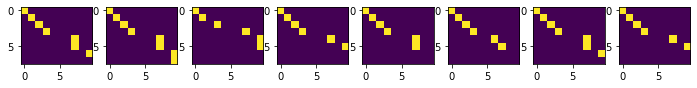

In [6]:
fake_images = generate_random_layout(real_dataset,batch_size=8)
plt.figure(figsize=(12,5))
for i in range(fake_images[0].shape[0]):
    plt.subplot(1,fake_images[0].shape[0],i+1)
    plt.imshow(fake_images[0][i,:,:-4])
plt.show()
#fake_images[0][0,:,:-4]

In [7]:
#固定的随机layout
#fixed_z_file = './fixed_z/fixed_xyaw_{0}_{1}.pkl'.format(dataset,'_'.join([str(r) for r in rooms]))

if not os.path.exists(fixed_z_file):
    fixed = generate_random_layout(real_dataset, 8)
    #fixed_images = [torch.tensor(x).to(device) for x in fixed]
    with open(fixed_z_file, 'wb') as output:
        pickle.dump(fixed,output)
    print('generating'+ fixed_z_file)

In [8]:
with open(fixed_z_file, 'rb') as pkl_file:
    fixed_z = pickle.load(pkl_file)
fixed_z = [torch.tensor(x).to(device) for x in fixed_z]

In [9]:
fixed_z

[tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.4979, 0.4945, 0.3493, 0.3269],
          [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.3051, 0.4893, 0.2191, 0.1895],
          [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.6155, 0.5447, 0.0940, 0.1022],
          [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.6738, 0.6095, 0.1094, 0.1596],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
           0.0000, 0.0000, 0.3411, 0.1911, 0.1426, 0.1324],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 1.0000, 0.5548, 0.6829, 0.0676, 0.0441],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.00

### 2.3 初始化

In [10]:
######################################################
learning_rate = 0.00005
clamp_num = 0.01
num_epochs = 3000 
tensorboard_interval = 100
discriminator_losses=[]
generator_losses=[]
boundray_losses=[]
######################################################

import models
reload(models)
from models import Generator, VectorDiscriminator, WireframeDiscriminator, weight_init

generator = Generator(dataset=real_dataset)
generator.apply(weight_init)
generator = nn.DataParallel(generator)
generator.to(device)
discriminator = VectorDiscriminator(dataset=real_dataset)
render = WireframeDiscriminator(dataset=real_dataset).render
discriminator.apply(weight_init)
discriminator = nn.DataParallel(discriminator)
discriminator.to(device)


#Initialize optimizers.
generator_optimizer = optim.RMSprop(generator.parameters(), learning_rate)
discriminator_optimizer = optim.RMSprop(discriminator.parameters(), learning_rate)#Wasserstein GAN推荐使用RMSProp优化

if os.path.exists(pkl_name):
    checkpoint = torch.load(pkl_name)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
    epoch_last = checkpoint['epoch']
    n_iter = checkpoint['n_iter']
    print('load_previous_model')
else:
    epoch_last = 0
    # global step
    n_iter = -1
    print('create_new_model')

create_new_model


In [11]:
print('amount of parameters in generator:\t',sum(p.numel() for p in generator.parameters() if p.requires_grad))
print('amount of parameters in discriminator:\t',sum(p.numel() for p in discriminator.parameters() if p.requires_grad))

amount of parameters in generator:	 378133011
amount of parameters in discriminator:	 10777626


### 检查rasterazition

In [14]:
batch = iter(real_dataloader).next()
batch = [x.to(device) for x in batch]
batch

[tensor([[[1.0000, 0.0000, 0.0000,  ..., 0.4395, 0.3789, 0.3555],
          [0.0000, 1.0000, 0.0000,  ..., 0.6816, 0.1914, 0.1680],
          [0.0000, 0.0000, 1.0000,  ..., 0.2344, 0.1328, 0.1406],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.8125, 0.1484, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[1.0000, 0.0000, 0.0000,  ..., 0.5546, 0.2737, 0.4611],
          [0.0000, 1.0000, 0.0000,  ..., 0.6816, 0.1523, 0.2070],
          [0.0000, 0.0000, 1.0000,  ..., 0.2715, 0.1523, 0.0820],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.8320, 0.1953, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.2285, 0.2383, 0.1680],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[1.0000, 0.0000, 0.0000,  ..., 0.4609, 0.2969, 0.5156],
          [0.0000, 1.0000, 0.0000,  ..., 0.7344, 0.1758, 0.1953],
          [0.0000, 0.0000, 1.0000,  ...,

In [15]:
generated = generator(batch[0],batch[1])

In [16]:
generated[0].shape

torch.Size([128, 8, 14])

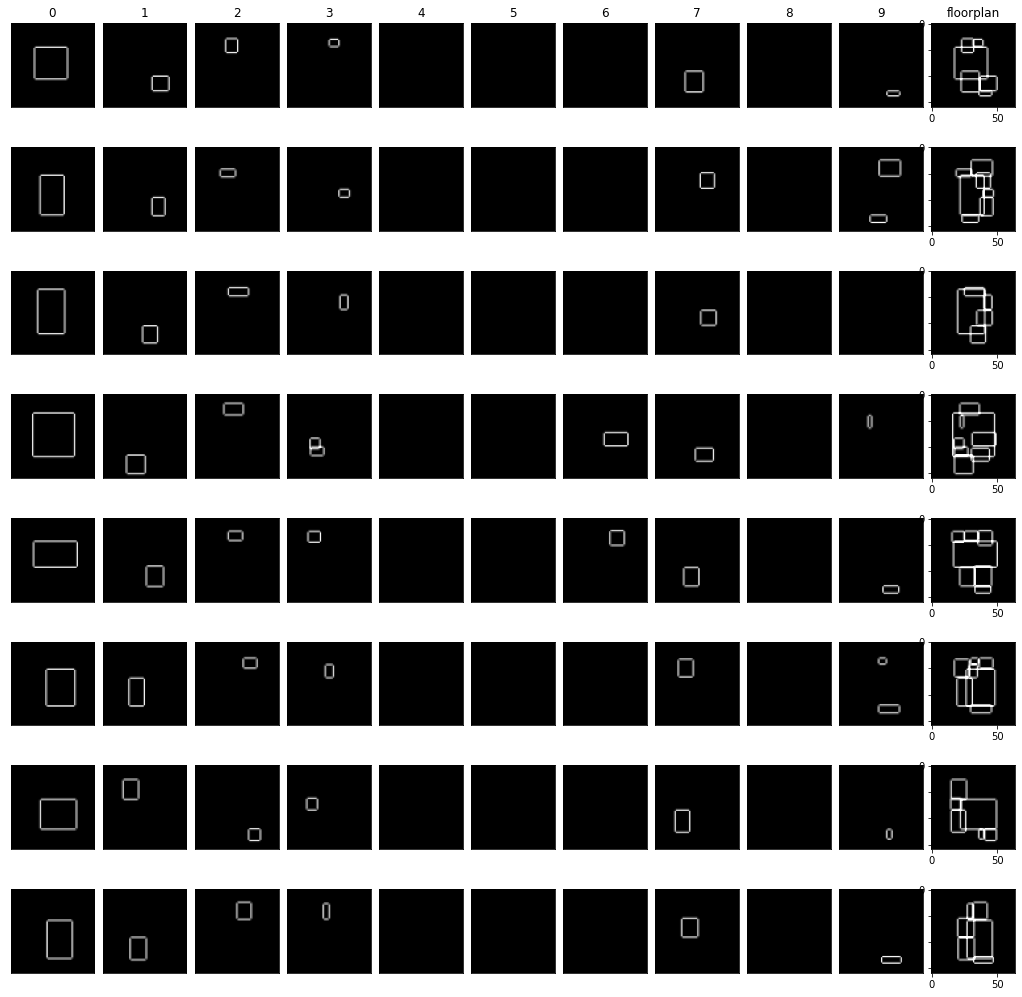

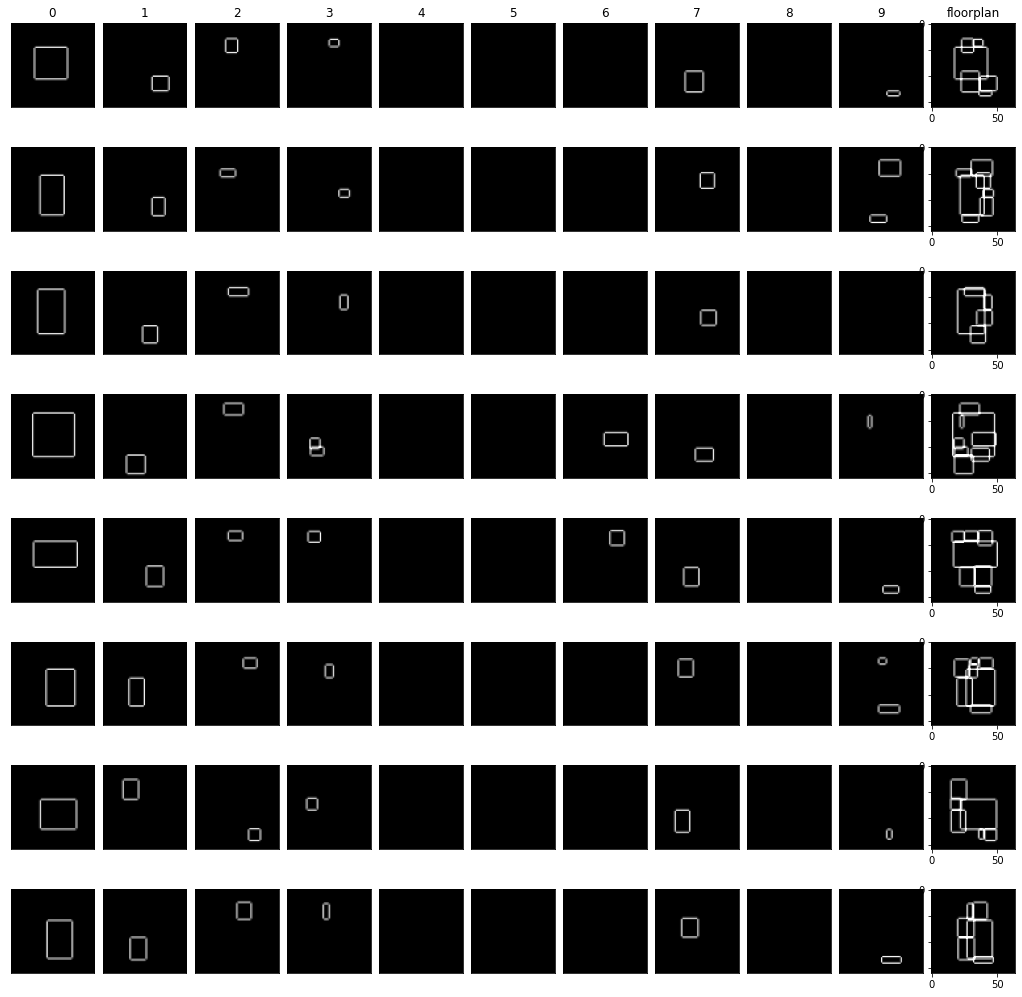

In [17]:
get_figure(render(generated[0][:8]))

In [20]:
pred = discriminator(batch[0],batch[1])
pred.mean()

tensor(-0.3249, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
get_figure(render(batch[0][:8]))

In [ ]:
draw_table(batch[0][0])

### 2.4 训练

In [ ]:
#log_dir = 'G_test'
if tensorboard:
    writer = SummaryWriter(log_dir=log_dir+'/'+date+' '+time_)

#固定的随机噪声
with open(fixed_z_file, 'rb') as pkl_file:
    fixed_z = pickle.load(pkl_file)
fixed_z = [torch.tensor(x).to(device) for x in fixed_z]
discriminator.eval()
fig_fixed= get_figure(render(fixed_z[0].detach()))
if tensorboard:
    writer.add_figure('fixed Z Image', fig_fixed, 1)

In [ ]:
real_images = iter(real_dataloader).next()
real_images = [x.to(device) for x in real_images]

In [ ]:
random_images = generate_random_layout(real_dataset,batch_size)
random_images = [torch.tensor(x).to(device) for x in random_images]

In [ ]:
get_figure(render(random_images[0][:4])).show()

In [ ]:
fake_images = generator(random_images[0],random_images[1])
get_figure(render(fake_images[0][:4])).show()

In [ ]:
# Start training.
for ec in range(num_epochs):
    epoch = ec + epoch_last
    print('Start to train epoch %d.' %(epoch))

    for batch_i, real_images in enumerate(real_dataloader,0):
        n_iter+=1

        print('\t iter {0} | batch {1} of epoch {2}'.format(n_iter, batch_i, epoch))

        discriminator.train()
        generator.train()

        '''real_images = [torch.cat([F.relu(torch.normal(mean=real_images[0][:,:,:-4],std=0.02)),\
                                  real_images[0][:,:,-4:]],axis=-1),\
                       real_images[1]]#向真实数据加噪声'''
        real_images = [x.to(device) for x in real_images]

        random_images = generate_random_layout(real_dataset,batch_size)
        random_images = [torch.tensor(x).to(device) for x in random_images]

        '''for parm in discriminator.parameters():
            parm.data.clamp_(-clamp_num, clamp_num)#权重裁剪'''

        # 训练判别器
        discriminator.zero_grad()
        pred_real = discriminator(real_images[0])
        pred_real.backward(torch.ones_like(pred_real).to(device))

        fake_images = generator(random_images[0],random_images[1])
        pred_fake = discriminator(fake_images[0].detach())
        pred_fake.backward(-torch.ones_like(pred_real).to(device))

        ##Gradient Penalty
        alpha = torch.rand(batch_size, 1, 1)
        alpha = alpha.expand(real_images[0].size())
        alpha = alpha.to(device)
        interpolates = alpha * real_images[0] + (1 - alpha) * fake_images[0].detach()
        interpolates = torch.autograd.Variable(interpolates, requires_grad=True)
        pred_interpolates = discriminator(interpolates)
        gradients = torch.autograd.grad(outputs=pred_interpolates, inputs=interpolates,
                          grad_outputs=torch.ones(pred_interpolates.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10 #LAMBDA
        gradient_penalty.backward()


        discriminator_optimizer.step()

        discriminator_loss = pred_fake.mean() - pred_real.mean() + gradient_penalty

        if tensorboard:
            discriminator_losses.append(discriminator_loss.cpu().detach().numpy())

        if (batch_i+1)%5 == 0:
        # 训练生成器
            generator.zero_grad()

            boundray_loss = bounds_check(fake_images[0])
            boundray_loss.backward(retain_graph=True)

            pred_fake = discriminator(fake_images[0])

            pred_fake.backward(torch.ones_like(pred_real).to(device))
            generator_optimizer.step()

            generator_loss = pred_fake.mean()

            if tensorboard:
                generator_losses.append(generator_loss.cpu().detach().numpy())
                boundray_losses.append(boundray_loss.cpu().detach().numpy())


        # TensorboardX
        if n_iter%tensorboard_interval == tensorboard_interval-1:
            discriminator_losses = np.array(discriminator_losses)
            generator_losses = np.array(generator_losses)
            boundray_losses = np.array(boundray_losses)

            print('\t\t N_iter {:7d} | Epoch [{:5d}/{:5d}] | discriminator_loss: {:6.4f} | generator_loss: {:6.4f}'.
                format(n_iter, epoch, num_epochs, discriminator_losses.mean(), generator_losses.mean()))
            if tensorboard:
                generator.eval()
                discriminator.eval()

                #记录梯度
                try:
                    G_grads = [(name,weight.grad.mean()) for name, weight in generator.named_parameters() if weight.requires_grad]
                    writer.add_scalar('G_grads 0 {}'.format(G_grads[0][0]), \
                        G_grads[0][1], n_iter)
                    writer.add_scalar('G_grads -1 {}'.format(G_grads[-1][0]), \
                        G_grads[-1][1], n_iter)
                except:
                    print('G_layer_zero_grad')

                try:
                    D_grads = [(name,weight.grad.mean()) for name, weight in discriminator.named_parameters() if weight.requires_grad]
                    writer.add_scalar('D_grads 0 {}'.format(D_grads[0][0]), \
                        D_grads[0][1], n_iter)
                    writer.add_scalar('D_grads -1 {}'.format(D_grads[-1][0]), \
                        D_grads[-1][1], n_iter)
                except:
                    print('D_layer_zero_grad')

                #记录loss
                writer.add_scalar('Discriminator Loss', discriminator_losses.mean(), n_iter)
                writer.add_scalar('Generator Loss', generator_losses.mean(), n_iter)
                writer.add_scalar('Boundray Loss', boundray_losses.mean(), n_iter)

                #记录网络权重
                for name, param in discriminator.named_parameters():
                    writer.add_histogram('Discriminator: '+ name, param.clone().detach().cpu().data.numpy(), n_iter)
                for name, param in generator.named_parameters():
                    writer.add_histogram('Generator: '+ name, param.clone().detach().cpu().data.numpy(), n_iter)

                #每个epoch向tensorboard添加recall

                real_pred = pred_real.detach().cpu().numpy()
                random_pred = discriminator(random_images[0]).detach().cpu().numpy()
                fake_pred = pred_fake.detach().cpu().numpy()

                acc = plt.figure(figsize=(10,5))
                ax = acc.add_subplot(111)
                ax.hist(real_pred,alpha=0.5, density=True,bins=60)
                ax.hist(random_pred,alpha=0.5, density=True,bins=60)
                ax.hist(fake_pred,alpha=0.5, density=True,bins=60)
                ax.legend(['real_pred','random_pred','fake_pred'])
                writer.add_figure('prediction',acc, n_iter)


                #可视化真实图像,添加到tensorboard
                fig_real= get_figure(render(real_images[0][:8]))
                writer.add_figure('Real Image',fig_real,n_iter)

                #可视化Z生成图像
                generated_z = generator(fixed_z[0],fixed_z[1])
                fig_fake = get_figure(render(generated_z[0]))
                writer.add_figure('Fake Image',fig_fake, n_iter)

                table = draw_table(generated_z[0][4])
                writer.add_figure('generated[4]',table, n_iter)

            discriminator_losses=[]
            generator_losses=[]
            boundray_losses=[]


    #在确认模型有效之前，暂不保存模型参数
    torch.save({
            'generator_state_dict': generator.state_dict(),
            'generator_optimizer_state_dict': generator_optimizer.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict(),
            'epoch': epoch,
            'n_iter':n_iter,
            }, pkl_name)
    print('\tparams saved to '+ pkl_name)

if tensorboard:
    writer.close()

In [ ]:
writer.close()

In [ ]:
generator.apply(weight_init)


In [ ]:
generator.module.encoder_fc0.weight

In [ ]:
pred_real = discriminator(real_images[0])
discriminator_real_loss = real_loss(pred_real, smooth=0.9)
discriminator_real_loss

In [ ]:
fake_images = generator(random_images[0],random_images[1])
pred_fake = discriminator(fake_images[0].detach())
discriminator_fake_loss = fake_loss(pred_fake, smooth=0.1)#label smoothing
discriminator_fake_loss

In [ ]:
pred_fake = discriminator(fake_images[0])
generator_loss = real_loss(pred_fake, False)
generator_loss

In [ ]:
random_images2 = generate_random_layout(real_dataset,batch_size)
random_images2 = [torch.tensor(x).to(device) for x in random_images2]
fake_images2 = generator(random_images2[0],random_images2[1])
pred_fake2 = discriminator(fake_images2[0])
generator_loss2 = real_loss(pred_fake2, False)
generator_loss2

In [ ]:
for name, param in generator.named_parameters():
    print(name,param.clone().detach().cpu().data.numpy())

In [ ]:
param

In [ ]:
param.detach().cpu().data.numpy()

In [ ]:
writer.close()

In [ ]:
pred_fake

In [ ]:
discriminator.train()
generator.train()

real_images = iter(real_dataloader).next()
real_images = [torch.cat([torch.normal(mean=real_images[0][:,:,:-2],std=0.02),real_images[0][:,:,-2:]],axis=-1),real_images[1]]#向真实数据加噪声
real_images = [x.to(device) for x in real_images]

random_images = generate_random_layout(real_dataset,batch_size)
random_images = [torch.tensor(x).to(device) for x in random_images]

fake_images = generator(random_images[0],random_images[1])

In [ ]:
real_images[0][0]

In [ ]:
get_figure(render(real_images[0][:8])).show()
#fake_images

In [ ]:
elements = real_images[0][:8]
batch_size = elements.shape[0]
num_elements =elements.shape[1]#batch_size,46,13
rects = elements[:,:,-4:]#batch_size,46,4
class_ = elements[:,:,:-4]#batch_size,46,9

coor_x = torch.arange(64).unsqueeze(1).expand(64,64).T\
        .expand(batch_size,num_elements,64,64).to(device)
coor_y = coor_x.transpose(2,3).to(device)

x = rects[:,:,0].reshape(batch_size,-1,1,1)*64#batch_size,46,1,1
y = rects[:,:,1].reshape(batch_size,-1,1,1)*64
area_root = rects[:,:,2].reshape(batch_size,-1,1,1)*64**2
w = (area*aspect_ratio)**0.5

h = area/w
try:
    h[h != h] = 0
except:
    pass

x0 = x-0.5*w
x1 = x+0.5*w
y0 = y-0.5*h
y1 = y+0.5*h 

In [ ]:
h

In [ ]:
# 训练判别器
pred_real = discriminator(real_images[0])
discriminator_real_loss = real_loss(pred_real, smooth=0.8)#label smoothing

fake_images = generator(random_images[0],random_images[1])
pred_fake = discriminator(fake_images[0].detach())
discriminator_fake_loss = fake_loss(pred_fake, smooth=0.2)#label smoothing

discriminator_loss = discriminator_real_loss + discriminator_fake_loss

In [ ]:
discriminator_loss

In [ ]:
discriminator.zero_grad()
discriminator_loss.backward()

discriminator_optimizer.step()
discriminator_scheduler.step()

In [ ]:
D_grads = [(name,weight.grad.mean()) for name, weight in discriminator.named_parameters() if weight.requires_grad]
D_grads

In [ ]:
# 训练生成器
pred_fake = discriminator(fake_images[0])
generator_loss = real_loss(pred_fake, False)
pred_fake

In [ ]:
generator_loss

In [ ]:
generator.zero_grad()
generator_loss.backward()
G_grads = [(name,weight.grad.mean()) for name, weight in generator.named_parameters() if weight.requires_grad]
G_grads

In [ ]:
random_images2 = generate_random_layout(real_dataset,batch_size)
random_images2 = [torch.tensor(x).to(device) for x in random_images2]
fake_images2 = generator(random_images2[0],random_images2[1])
pred_fake2 = discriminator(fake_images2[0])
generator_loss2 = real_loss(pred_fake2, False)
generator_loss2.backward()

generator_optimizer.step()
generator_scheduler.step()

In [ ]:
render(fake_images[0])[0].shape


In [ ]:
pred_fake

In [ ]:
generator.eval()
discriminator.eval()
calc_images = calc_iter.next()
calc_images =[x.to(device) for x in calc_images]
fake_images = generate_random_layout(real_dataset,batch_size)
fake_images = [torch.tensor(x).to(device) for x in fake_images]
generated_images = generator(fake_images[0],fake_images[1])

real_pred = discriminator(calc_images[0]).detach().cpu().numpy()
fake_pred = discriminator(fake_images[0]).detach().cpu().numpy()
generated_pred = discriminator(generated_images[0]).detach().cpu().numpy()

In [ ]:
print()
get_figure(discriminator.render(calc_images[0][:8])).show()

In [ ]:
get_figure(discriminator.render(fake_images[0][:8])).show()

In [ ]:
plt.hist(real_pred,alpha=0.7, density=True,range=(0.,1.),bins=60)
plt.show()
#real_loss(discriminator_real, False)

In [ ]:
real_loss(torch.tensor([0.5,]))

In [ ]:
plt.hist(fake_pred,alpha=0.7, density=True,range=(0.,1.),bins=60)
plt.show()

In [ ]:
fake_loss(torch.tensor(fake_pred))

In [ ]:
plt.hist(generated_pred,alpha=0.7, density=True,range=(0.,1.),bins=60)
plt.show()

In [ ]:
x = np.linspace(0,1)
y_f= np.array([fake_loss(torch.tensor([d,])).numpy() for d in x])
y_r = np.array([real_loss(torch.tensor([d,])).numpy() for d in x])
plt.figure()
plt.plot(x,y_f)
plt.plot(x,y_r)
plt.legend(['fake loss','real loss'])

In [ ]:
fake_loss(torch.tensor(fake_pred))

In [ ]:
fake_images

In [ ]:
get_figure(discriminator.render(generated_images[0][:8]).detach()).show()

In [ ]:
fake_images[0]

In [ ]:
generated_pred

In [ ]:
writer.close()

# metrics

In [ ]:
import models
reload(models)
from models import Generator, WireframeDiscriminator
pkl_name = './params/params_rplan_cuda:0_2020-11-20.pkl'

generator = Generator(device=device,n_gpu=1,dataset=real_dataset)
discriminator = WireframeDiscriminator(device=device,n_gpu=1,dataset=real_dataset,rendered_size=64)
render = discriminator.render

# Leaning rate for optimizers
learning_rate = 0.00002
print('Initialize optimizers.')
generator_optimizer = optim.Adam(generator.parameters(), learning_rate)
discriminator_optimizer = optim.Adam(discriminator.parameters(), learning_rate/4)

if os.path.exists(pkl_name):
    checkpoint = torch.load(pkl_name)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
    epoch_last = checkpoint['epoch']
    n_iter = checkpoint['n_iter']
    print('load_previous_model')
else:
    epoch_last = 0
    # global step
    n_iter = -1
    print('create_new_model')

### 面积pca

In [ ]:
real_batch = iter(real_dataloader).next()
real_batch = [x.to(device) for x in real_batch]
real_batch

In [ ]:
get_figure(render(real_batch[0][:8])).show()

In [ ]:
random_batch = generate_random_layout(real_dataset,batch_size)
random_batch = [torch.tensor(x).to(device) for x in random_batch]
random_batch

In [ ]:
get_figure(render(random_batch[0][:8])).show()

In [ ]:
fake_batch = generator(random_batch[0],random_batch[1])
fake_batch

In [ ]:
get_figure(render(fake_batch[0][:8])).show()

In [ ]:
real = real_batch[0][:,:,-2].cpu().numpy()
random = random_batch[0][:,:,-2].cpu().numpy()
fake = fake_batch[0][:,:,-2].detach().cpu().numpy()
real.shape

In [ ]:
real_ = np.array([real_dataset[i][0][:,-2] for i in tqdm(range(len(real_dataset)))])

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(real_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

In [ ]:
real_new = pca.transform(real)
random_new = pca.transform(random)
fake_new = pca.transform(fake)
real_new

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(real_new[:, 0], real_new[:, 1], real_new[:, 2],c='r',marker='o')
ax.scatter(random_new[:, 0], random_new[:, 1], random_new[:, 2],c='b',marker='o')
ax.scatter(fake_new[:, 0], fake_new[:, 1], fake_new[:, 2],c='g',marker='o')
plt.legend(['real','random','fake'])
plt.show()

### M距离pca

In [ ]:
def get_mdistance(batch):
    if len(batch[0].shape)==3:
        livingroom = batch[0][:,0:1,-4:-2].detach().cpu().numpy()
        otherrooms = batch[0][:,1:,-4:-2].detach().cpu().numpy()
    elif len(batch[0].shape)==2:
        livingroom = batch[0][0:1,-4:-2]
        otherrooms = batch[0][1:,-4:-2]
    mdistance = (np.abs(otherrooms-livingroom)).sum(axis=-1)
    return mdistance
temp = get_mdistance(real_batch)
temp.shape

In [ ]:
real = get_mdistance(real_batch)
random = get_mdistance(random_batch)
fake = get_mdistance(fake_batch)
real

In [ ]:
real_ = np.array([get_mdistance(real_dataset[i]) for i in tqdm(range(len(real_dataset)))])

In [ ]:
real_[0]

In [ ]:
pca = PCA(n_components=2)
pca.fit(real_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

In [ ]:
real_new = pca.transform(real)
random_new = pca.transform(random)
fake_new = pca.transform(fake)

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(real_new[:, 0], real_new[:, 1], real_new[:, 2],c='r',marker='o')
ax.scatter(random_new[:, 0], random_new[:, 1], random_new[:, 2],c='b',marker='o')
ax.scatter(fake_new[:, 0], fake_new[:, 1], fake_new[:, 2],c='g',marker='o')
plt.legend(['real','random','fake'])
plt.show()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.scatter(real_new[:, 0], real_new[:, 1],c='r',marker='o')
ax.scatter(random_new[:, 0], random_new[:, 1],c='b',marker='o')
ax.scatter(fake_new[:, 0], fake_new[:, 1],c='g',marker='o')
plt.legend(['real','random','fake'])
plt.show()

### 直观可视化

In [ ]:
real_dataset.dict_room_encode

In [ ]:
rooms

In [ ]:
real_batch

## 检查generator forward passing

In [ ]:
loaded=fixed_z
draw_table(loaded[0][0]).show()

In [ ]:
fig_fake = get_figure(discriminator.render(loaded[0]).detach())
fig_fake.show()

In [ ]:
generated = generator(loaded[0],loaded[1])
draw_table(generated[0][1]).show()

In [ ]:
fig_fake = get_figure(discriminator.render(generated[0]).detach())
fig_fake.show()

In [ ]:
rendered = discriminator.render(generated[0]).detach()
draw_table(rendered[1,0,:20,:20]).show()

In [ ]:
real_images[0][0,:,-4:]


In [ ]:
rendered = discriminator.render(real_images[0][:8]).detach()
draw_table(rendered[1,0,:20,:20]).show()

In [ ]:
input_ = torch.arange(0,24,1.0).reshape(2,3,4)
input_

In [ ]:
input_.permute(0,2,1).reshape(8,3)

In [ ]:
N, C, H, W = 2,3,5,10
f_k = input_.reshape([N, C, H*W]).permute(0, 2, 1)#[2,50,3]
f_q = input_.reshape([N, C, H*W])#[2,3,50]
w = torch.matmul(f_k, f_q)/(H*W)#[2, 50, 50]

In [ ]:
f_r2 = torch.matmul(input_.reshape([N, C, H*W]),w)
f_r = torch.matmul(w.permute(0, 2, 1),input_.reshape([N, C, H*W]).permute(0, 2, 1)).permute(0, 2, 1)

In [ ]:
t = torch.arange(12).reshape(3,4)
t2 = t.transpose(0,1)

In [ ]:
t.data_ptr()

In [ ]:
t2.data_ptr()

In [ ]:
f_r.shape

In [ ]:
f_r = f_r.permute(0,2,1)
f_r.shape

In [ ]:
f_r.stride()

In [ ]:
f_r = f_r.permute(0,2,1)
f_r.shape

In [ ]:
f_r.stride()

In [ ]:
f_r = f_r.reshape(N,C,H,W)
f_r2 = f_r2.reshape(N,C,H,W)

In [ ]:
f_r-f_r2

In [ ]:
torch.matmul(input_.reshape(2,3,50).permute(0,2,1), input_.reshape(2,3,50)).shape

In [ ]:
fake_rectangles = generate_fake_dicts_rect(len(rectangles.keys()),mu, sigma, mean, cov, rect_types)
fake_dataset = wireframeDataset(fake_rectangles,maximum_elements_num,dict_room_encode)
fake_dataloader = DataLoader(fake_dataset,batch_size,shuffle=False,num_workers=0)
fake_images = iter(fake_dataloader).next()
fake_images = [x.to(device).detach() for x in fake_images]
fake_images

In [ ]:
fig= get_figure(discriminator.render(loaded[0]))
fig.show()

In [ ]:
input_data = [0]
input_length = fake_images[1]
generated = generator(input_data,input_length)
generated

In [ ]:
generated[0].contiguous()

In [ ]:
pd.DataFrame(generated[0][0].cpu().detach().numpy()).to_csv('generated.csv')

In [ ]:
fig= get_figure(discriminator.render(generated[0]))
fig.show()

In [ ]:
input_data = fake_images[0]
input_length = fake_images[1]
title=['xc','w','yc','h']
plt.figure(figsize=(15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(input_data[:,:,-4+i].detach().cpu().numpy().flatten(), 30,density=1, alpha=0.75) 
    plt.title(title[i])
plt.show()

In [ ]:
out = F.relu(generator.encoder_fc1(fake_images[0]))
print(out.shape)
plt.hist(out.detach().flatten().cpu().numpy(),bins=30)

In [ ]:
out = F.relu(generator.encoder_fc2(out))
print(out.shape)
plt.hist(out.detach().flatten().cpu().numpy(),bins=30)

In [ ]:
out

In [ ]:
encoded = torch.sigmoid(generator.encoder_fc3(out))
print(encoded.shape)
plt.hist(encoded.detach().flatten().cpu().numpy(),bins=30)

In [ ]:
encoded

In [ ]:
relation_residual_1 = models.relation_module(encoded, generator.device, generator.relation1_unary, generator.relation1_psi,
                                              generator.relation1_phi, generator.relation1_wr,input_length)
print(relation_residual_1.shape)
plt.hist(relation_residual_1.detach().flatten().cpu().numpy())        

In [ ]:
relation_residual_2 = models.relation_module(relation_residual_1, generator.device, generator.relation2_unary, generator.relation2_psi,
                                              generator.relation2_phi, generator.relation2_wr,input_length)
print(relation_residual_2.shape)
plt.hist(relation_residual_2.detach().flatten().cpu().numpy())     

In [ ]:
out = F.relu(generator.decoder_fc1(relation_residual_2))
print(out.shape)
plt.hist(out.detach().flatten().cpu().numpy())

In [ ]:
out = F.relu(generator.decoder_fc2(out))
print(out.shape)
plt.hist(out.detach().flatten().cpu().numpy())

In [ ]:
out

In [ ]:
syn_cls = generator.sigmoid_brach1(generator.branch_fc1(out))
syn_geo = generator.sigmoid_brach2(generator.branch_fc2(out))

In [ ]:
syn_geo

In [ ]:
# Synthesized layout
res = torch.cat((syn_cls, syn_geo), 2)
batch_size, maximum_elements_num, feature_size = input_data.shape
mask_l = [torch.cat([torch.ones(l,feature_size),torch.zeros(maximum_elements_num-l,feature_size)]) for l in input_length.cpu().numpy()]
mask = torch.stack(mask_l)
mask = mask.to(generator.device)
res = res.mul(mask)
print(res.shape)
plt.hist(res.detach().flatten().cpu().numpy(),bins=200)

In [ ]:
discriminator.eval()
fig= get_figure(discriminator.render(fake_images[0]))
fig.show()

In [ ]:
generator.train()
fake_images2 = generator(fake_images)
fake_images2

In [ ]:
fig= get_figure(discriminator.render(fake_images2[0]))
fig.show()

In [ ]:
torch.mm(torch.Tensor(52,1).t(),torch.Tensor(52,1))

## 检查discriminator forward passing

In [ ]:
real_images = iter(real_dataloader).next()
real_images = [x.to(device) for x in real_images]
real_images

In [ ]:
rendered = discriminator.render(real_images[0][:8])
get_figure(rendered).show()

In [ ]:
rendered.shape

In [ ]:
cnn = nn.Sequential(
            nn.Conv2d(10,64,kernel_size=5,stride=2,padding=2,bias=False),#padding=2,same
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),#32, rendered_size/2, rendered_size/2

            nn.Conv2d(64,128,kernel_size=5,stride=2,padding=2,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),#64, rendered_size/4, rendered_size/4

            nn.Conv2d(128,256,kernel_size=5,stride=2,padding=2,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),#128, rendered_size/8, rendered_size/8
        ).to(device)


In [ ]:
cnn(rendered)

In [ ]:
discriminator(real_images[0])

In [ ]:
cnned = discriminator.cnn(rendered)
cnned = cnned.squeeze()
print(cnned.shape)
fig = plt.figure(figsize=(5,30))
for b in range(batch_size):
    ax = fig.add_subplot(batch_size,1,b+1) 
    ax.hist(cnned.detach().cpu().numpy()[b],bins = 60)
    ax.set_ylim([0,50])
fig.show()

# test

In [ ]:
fake_rectangles = generate_fake_dicts_rect(len(rectangles.keys()),mu, sigma, mean, cov, rect_types)
fake_dataset = wireframeDataset(fake_rectangles,maximum_elements_num,dict_room_encode)
fake_dataloader = DataLoader(fake_dataset,batch_size,shuffle=False,num_workers=0)
batch = iter(fake_dataloader).next()
batch_fake = [x.to(device) for x in batch]
batch_fake

In [ ]:
batch = iter(real_dataloader).next()
batch_real = [x.to(device) for x in batch]
discriminator.eval()
render_real = discriminator.render(batch_real[0])
render_real.shape

In [ ]:
batch_real[0].shape

In [ ]:
discriminator.eval()
rendered = discriminator.render(batch_fake[0])
batch_size = rendered.shape[0]
batch_size

In [ ]:
fig = plt.figure(figsize=(18,32))
fig.show()

In [ ]:
plt.figure(figsize=(18,32))
for i in range(batch_size):
    for j in range(9):
        num = i*9+j+1
        plt.subplot(batch_size,9,num)
        plt.imshow(random[i,j,:,:].detach().cpu().numpy(),cmap='gray')
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        if i == 0:
            ax.set_title(list(dict_room_encode.keys())[j])
plt.subplots_adjust(wspace =0.1, hspace =0.1)
plt.show()

In [ ]:
#生成图像
generated = discriminator.render(batch_cuda[0])[0]
#plt.figure(figsize=(15,15))
for i in range(9):
    plt.figure(figsize=(5,5))
    #plt.subplot(3,3,i+1)
    plt.imshow(generated[i].detach().cpu().numpy(),cmap='gray')
    plt.title(list(dict_room_encode.keys())[i])
    plt.axis('off')
    plt.savefig('{}.png'.format(str(i)))
plt.show()

In [ ]:
generator(batch_cuda)[0]

In [ ]:
for param in generator.named_parameters():
    print(param[1].data)